## Training Deep Neural Network

### The Vanishing/Exploding Gradients Problems
```
This problem was one of the problem neural networks was  abandned in 2000s(along with weight initialization solved backpropagation)
The backpropagation algorithm propagating the error gradient from the output layer to the input layer.
After computing the gradient of the cost function w.r.t each parameter in the network,
it update each params with a `Gradient Descent step` using gradients_

* Vanishing gradient - gradients get smaller and smaller as the algorithm progresses down to the lower layers. Virtually no change in weights
* Exploding gradient - gradients grows bigger until layers get insanely large weight updates & algorithm diverges. Seen in RNN

Generally, DNN suffer from unstable gradients; different layers may learn at widely different speeds.

<center>
    <!-- <img src=""></img> -->
    <img src="img/img1.png" style="display: block; margin: auto;" />

<center>


### Glorot and He Initialization
#### equal no. of input and neurons, called fan-in and fan-out whereas $fan_{avg} = \frac{ ( fan_{in} + fan_{out} ) }{2}$
```
Glorot and Bengio presented the idea of initializing the connection weights of each
layer must be initialized randomly as described in Below Equation.
```
> Normal distribution with mean 0 and variance $σ2 = \frac{1}{fan_{avg}}$

> Or a uniform distribution between −r and + r, with $ r = \sqrt{\frac{3}{fan_{avg}}}$

```This initalization strategy called Xavier Initialization or Glorot Initialization.```

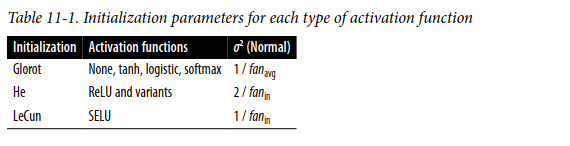



## Nonsaturating Activation Functions
    
```
The insight from Glorot and Bengio paper was problem with unstable gradient along with poor choice of activation func.
Unlike our brain, sigmoid func performed poorly in DNN, ReLU solved it but...
ReLU func often die i.e, stop outputting anything other than 0, called Dying ReLU, laregly seen during large learning_rate
    || reason - input weights being -ve --> ReLU = max(0, z)
* Leaky ReLU (LReLU) solved it with adding slope(leak)  = max(αz, z) where α = leak (0.01)
* Other ReLU varients like Randomized ReLU(RReLU), parametric leaky ReLU(PReLU), etc performed well
* Exponential Linear Unit (ELU) outperformed ReLU & its varients due to its
    * exponential graph combined with linear graph
    * nonzero gradient for z < 0, which avoids the dead neurons problem
    * Note: It is still slower than ReLUs due to its exponential function
```
<center>
    <img src="img/img2.png"></img>
</center>

### Scaled Exponential Linear Unit (SELU)
```
It showed that a DNN composed exclusively of a stack of dense layers, & if all hidden layers use SELU activation func,
then the network will self-normalize:
the output of each layer will tend to preserve mean=0 and standard deviation=1 during training,
which solves the vanishing/exploding gradients problem
```
#### However, the Conditions for SELU are

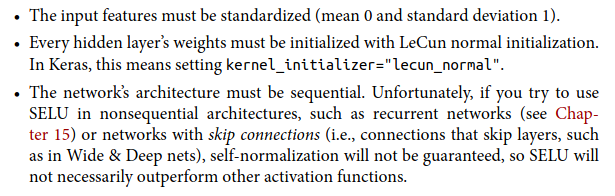

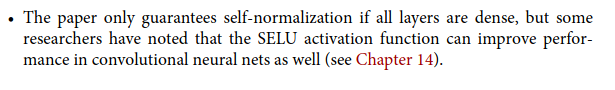

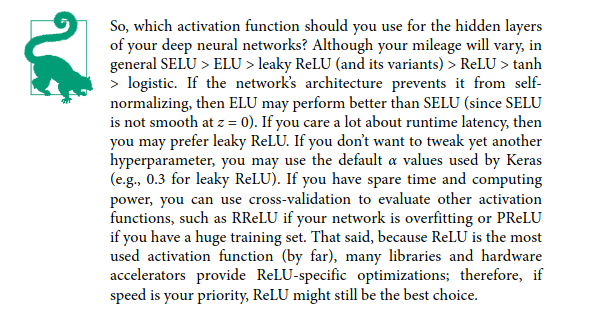

## Implementing both LReLU and SELU

In [1]:
import numpy as np
import tensorflow as tf
import keras

2025-07-07 04:46:07.542698: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 04:46:07.788474: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.3)


In [2]:
# scaling the data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [5]:
model = keras.Sequential([
    keras.layers.InputLayer(shape=(X_train.shape[1:])),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(1)
])

/home/krrish/anaconda3/envs/tf2_env/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [7]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-4))

In [8]:
%%time
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), verbose=0)

CPU times: user 7.38 s, sys: 714 ms, total: 8.1 s
Wall time: 5.71 s


In [9]:
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
print(mse_test)
y_pred = model.predict(X_new)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 0.5981
0.6172487139701843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


---
#### ANN with SELU activation function

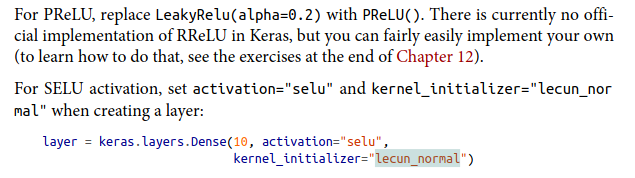

### Note:
> #### In Multi-layered SELU, use AlphaDropout() soinput of next layers be scaled with mean 0 and std.dev 1

> #### Optimizer like SGD are too aggressive to use, use Adam with low lr(0.001) for SELU

> #### Check for any $\phi$ or $\infty$  values too

> #### Avoid BatchNorm (incompatible with SELU)

> #### Initialize weights with lecun_normal

In [34]:
np.any(np.isnan(X_train)), np.any(np.isinf(X_train))

(np.False_, np.False_)

In [24]:
model_reg_semu = keras.Sequential([
    keras.layers.InputLayer(shape=(X_train.shape[1:])),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(0.1),
    keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(0.1),
    keras.layers.Dense(1)
])

In [25]:
model_reg_semu.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))

In [30]:
%%time
history_semu = model_reg_semu.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), verbose=0)

CPU times: user 12 s, sys: 948 ms, total: 12.9 s
Wall time: 8.34 s


In [31]:
mse_selu_test = model_reg_semu.evaluate(X_test, y_test)
X_new = X_test[:3]
print(mse_selu_test)
y_pred_selu = model_reg_semu.predict(X_new)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 0.7176
0.7082113027572632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [32]:
model_reg_semu.evaluate(X_test, y_test)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.7176


0.7082113027572632

---
### CNN with SELU activation function

> #### Use Older Verision of tensorflow or keras for it

In [6]:
tf.__version__, keras.__version__

('2.18.1', '3.6.0')

In [7]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_valid, X_train = X_train[:5000] / 255.0, X_train[5000:] / 255.0
y_valid, y_train = y_train[:5000] , y_train[5000:]

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

class_names[y_valid[0]]

'Ankle boot'

In [8]:
X_train = X_train.astype("float32")
X_valid = X_valid.astype("float32")
X_test  = X_test.astype("float32")

In [9]:
np.any(np.isnan(X_train)), np.any(np.isinf(X_train))

(np.False_, np.False_)

In [10]:
np.mean(X_train), np.var(X_train), np.std(X_train)

(np.float32(0.28603044), np.float32(0.12453916), np.float32(0.35290107))

In [9]:
# ⚠️ Step 2: Normalize to mean = 0, std = 1
# You can't use StandardScaler directly on (n, 28, 28).
# Instead, flatten before scaling, then reshape back to 28×28 for CNN:

from sklearn.preprocessing import StandardScaler

# Flatten images
X_train_flat = X_train.reshape(-1, 28*28)
X_valid_flat = X_valid.reshape(-1, 28*28)
X_test_flat  = X_test.reshape(-1, 28*28)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_valid_scaled = scaler.transform(X_valid_flat)
X_test_scaled  = scaler.transform(X_test_flat)

# Reshape back for CNN input (add channel dimension)
# here channel C=1 or grayscale
X_train_scaled = X_train_scaled.reshape(-1, 28, 28, 1)
X_valid_scaled = X_valid_scaled.reshape(-1, 28, 28, 1)
X_test_scaled  = X_test_scaled.reshape(-1, 28, 28, 1)

In [10]:
np.mean(X_train_scaled), np.var(X_train_scaled), np.std(X_train_scaled)

(1.0177245e-09, 1.0000001, 1.0)

In [12]:
from tensorflow import keras
    
model_clf_semu = keras.models.Sequential([
    # keras.layers.InputLayer(),
    keras.layers.Conv2D(32, (3, 3), activation="selu", kernel_initializer="lecun_normal", input_shape=(28, 28, 1)),
    # REMOVE AlphaDropout here
    keras.layers.Conv2D(64, (3, 3), activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(0.1),  # ✅ Safe here
    keras.layers.Dense(10, activation="softmax")
])

2025-07-02 09:50:27.445470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-02 09:50:27.452794: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
model_clf_semu.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [12]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2025_07_06-06_46_18'

In [11]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
    restore_best_weights=True)

In [13]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [18]:
from timeit import default_timer as timer

start_time = timer()
history_selu_cnn = model_clf_semu.fit(X_train_scaled, y_train, epochs=30, validation_data=(X_valid_scaled, y_valid),
                                     verbose=1, callbacks=[early_stopping_cb, tensorboard_cb])
end_time = timer()
total_time = end_time-start_time
print(f'Total Time Taken: {total_time}')

Epoch 1/30
1719/1719 [==============================] - 53s 31ms/step - loss: 0.3126 - accuracy: 0.8866 - val_loss: 0.3164 - val_accuracy: 0.8898
Epoch 2/30
1719/1719 [==============================] - 48s 28ms/step - loss: 0.2690 - accuracy: 0.9028 - val_loss: 0.3070 - val_accuracy: 0.9048
Epoch 3/30
1719/1719 [==============================] - 54s 32ms/step - loss: 0.2392 - accuracy: 0.9122 - val_loss: 0.3213 - val_accuracy: 0.9080
Epoch 4/30
1719/1719 [==============================] - 33s 19ms/step - loss: 0.2157 - accuracy: 0.9207 - val_loss: 0.2784 - val_accuracy: 0.9094
Epoch 5/30
1719/1719 [==============================] - 37s 22ms/step - loss: 0.1972 - accuracy: 0.9290 - val_loss: 0.3434 - val_accuracy: 0.9010
Epoch 6/30
1719/1719 [==============================] - 32s 19ms/step - loss: 0.1812 - accuracy: 0.9329 - val_loss: 0.3566 - val_accuracy: 0.9064
Epoch 7/30
1719/1719 [==============================] - 29s 17ms/step - loss: 0.1640 - accuracy: 0.9400 - val_loss: 0.3547 -

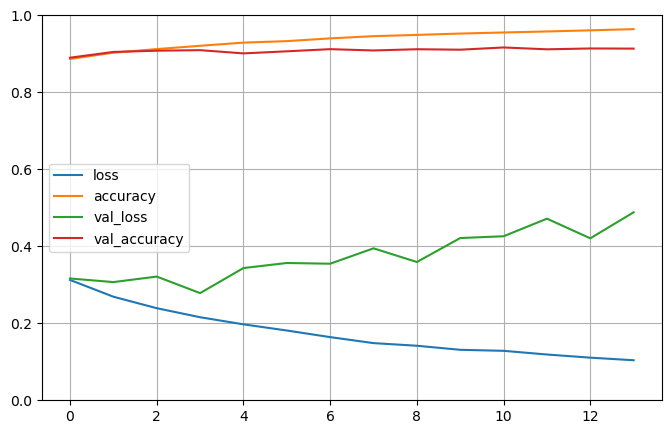

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history_selu_cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
# !tensorboard --logdir=./my_logs --port=6006

2025-07-02 10:13:22.978175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.0 at http://localhost:6006/ (Press CTRL+C to quit)


---
## Batch Normalizattion

```
Using He Initialization with ELU (or any ReLU varient) reduces danger of vanishing/exploding gradient
It doesn't gaurantee it won't appear again.
Thus, we use Batch Normalization


It works by evaluating the mean and std deviation of the input over the current mini-batch then zero-center and normalize input
It is seen many time, BN even standardize the input if added before input layer
```

###  Working of Batch Normalization


<img src='img/img3.png'></img>    
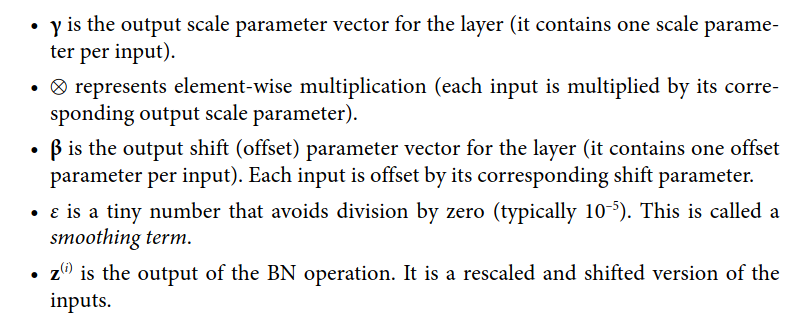

---
### Miscellenous



>  Applied to a state-of-the-art image classification model, Batch Normalization achieves
the same accuracy with 14 times fewer training steps, and beats the original model by a
significant margin. […] Using an ensemble of batch-normalized networks, we improve
upon the best published result on ImageNet classification: reaching 4.9% top-5 valida‐
tion error (and 4.8% test error), exceeding the accuracy of human raters.

> 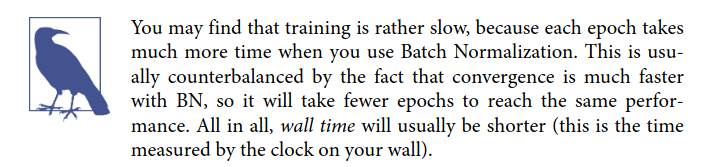

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_valid, X_train = X_train[:5000] / 255.0, X_train[5000:] / 255.0
y_valid, y_train = y_train[:5000] , y_train[5000:]

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

class_names[y_valid[0]]

'Ankle boot'

In [4]:
X_train = X_train.astype("float32")
X_valid = X_valid.astype("float32")
X_test  = X_test.astype("float32")

In [5]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

```
In last 2 layers of BN, there are some non-trainable params
Each BN layer calculate 4 var hence, gives 4*prev_input_shape (,784) -> 3,316

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [6]:
[(print(f'{var.name}, {var.trainable}')) for var in model.layers[1].variables]

gamma, True
beta, True
moving_mean, False
moving_variance, False


[None, None, None, None]

#### The Author of BN paper argues over benfit of using BN before activation function, but it depends on experiment

In [33]:
model = keras.models.Sequential([
    keras.layers.InputLayer(shape=[28,28]),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

In [7]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
from timeit import default_timer as timer

start_time = timer()
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid),
                                     verbose=1, callbacks=[early_stopping_cb])
end_time = timer()
total_time = end_time-start_time
print(f'Total Time Taken: {total_time}')

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.7635 - loss: 0.6912 - val_accuracy: 0.8594 - val_loss: 0.4134
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8472 - loss: 0.4325 - val_accuracy: 0.8664 - val_loss: 0.3772
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8605 - loss: 0.3907 - val_accuracy: 0.8698 - val_loss: 0.3654
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8686 - loss: 0.3675 - val_accuracy: 0.8788 - val_loss: 0.3461
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8777 - loss: 0.3442 - val_accuracy: 0.8772 - val_loss: 0.3364
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8835 - loss: 0.3249 - val_accuracy: 0.8814 - val_loss: 0.3324
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8863 - loss: 0.3202 - val_accuracy: 0.8820 - val_loss: 0.3363
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8890 - loss: 0

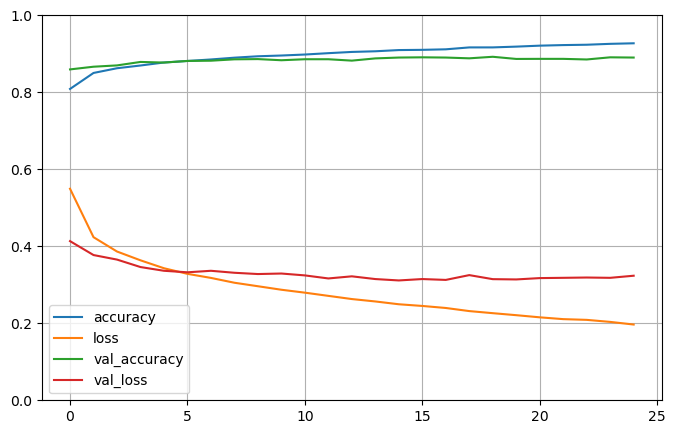

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

```
AlphaDropout also implement BN inside of it,
use_bias=False makes layer reject prev bias term

---

### Gradient Clipping

```
It is a technique used to mitigate the exploding gradients problem is to clip the
gradients during backpropagation so that they never exceed some threshold.
~ Used in RNN since applying BN in RNN is dificult
~ can be set by just clipvalue or clipnorm in optimizer

```
Setting clipvalue=1.0 clips all values to [-1, 1] like [3.5, -0.2] -> [1, -0.2]
but sometimes, [0.9,100] -> [0.9,1.0]
here grad vect indicate direction such that gradient is mostly in 2nd axis but after grad clip the data is loss
so, set clipnorm=0.1 such [0.9,100] -> [0.00899964, 0.9999595],

---
## Transfer Learning
> ### Using pretrained layers of other model instead of training new ones
> ### Freeze those layers, so gradient descent doesn't change them
> ### More similar task, more layers used
> 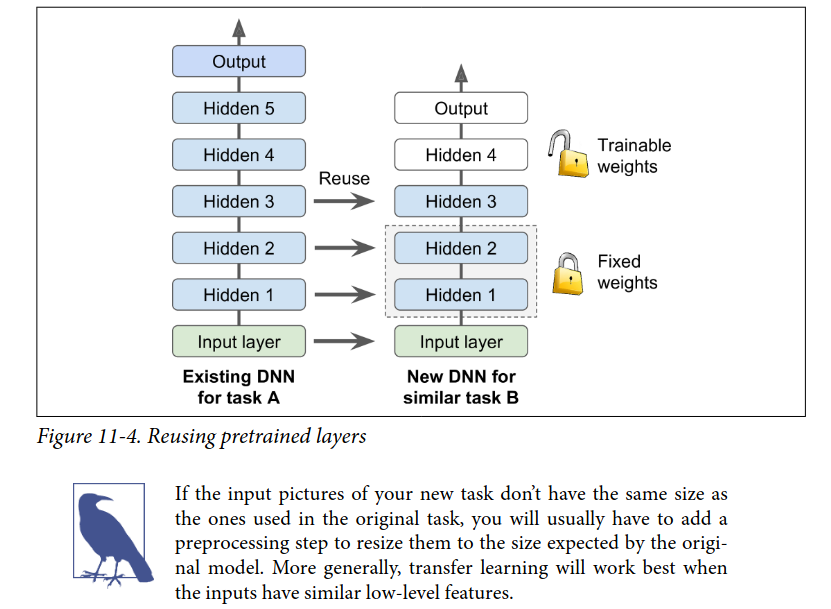 

### Transfer learning is best used when trained in Deep CNN

---
## Unsupervised Pretraining
```
It is often usely to train labelled model from unlabelled data

---
## Faster Optimizers
### Model can optimized by tweaking some of params such as
>### Applying a good initialization strategy for the connection weights
>### Using a good activation function
>### Using Batch Normalization
>### Reusing parts of a pretrained network (possibly built on an auxiliary task or using unsupervised learning)


---
## Momentum Optimization
```
It optimizes by using prev gradient of cost func to create momentum and add it in local gradient
```
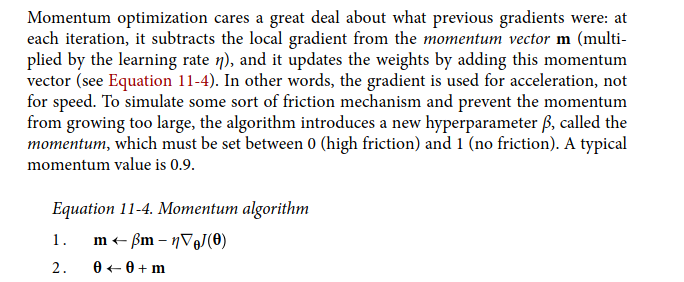

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

---
## Nesterov Accelerated Gradient (NAG)
``` It improves upon momentum optimization by just finding cost function slightly right/ahead of theta ```

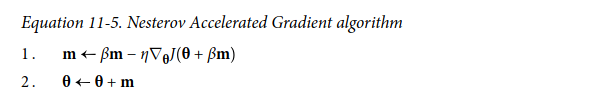

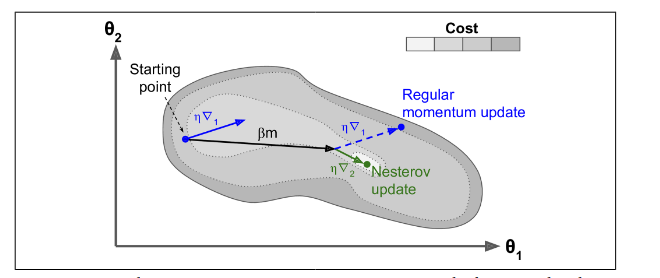


In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

---
## AdaGrad (Adaptive Gradient)
``` 
AdaGrad might be usefule for Linear Reg but it scales down weights too much in neural networks
and stops early before reaching global optimum.
```
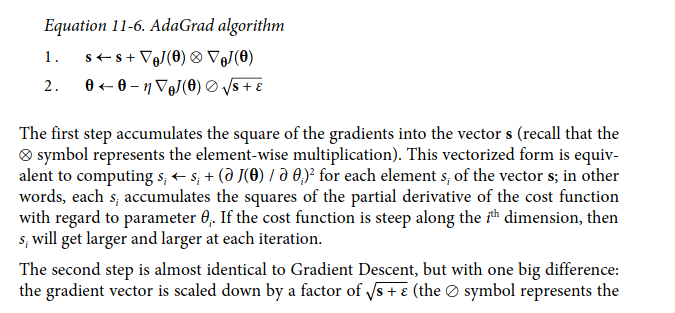 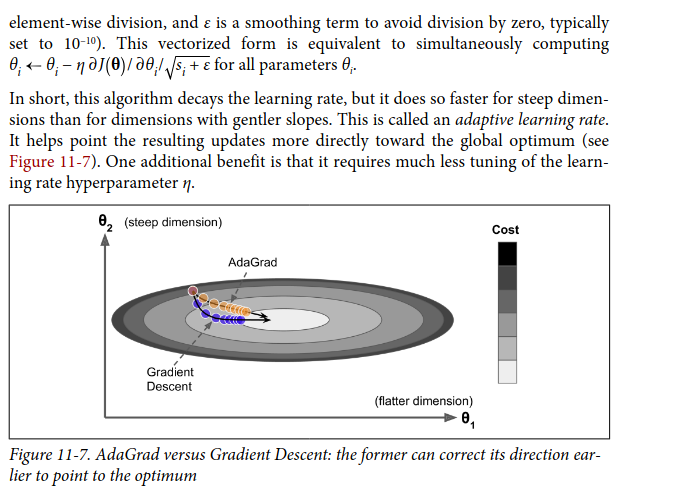

---
## RMSProp
```
It solves the problem of AdaGrad(stopping early before global optimum) by accumulating
only the gradients from the most recent iterations. Tt does so by exponential decay in 1st step.
```
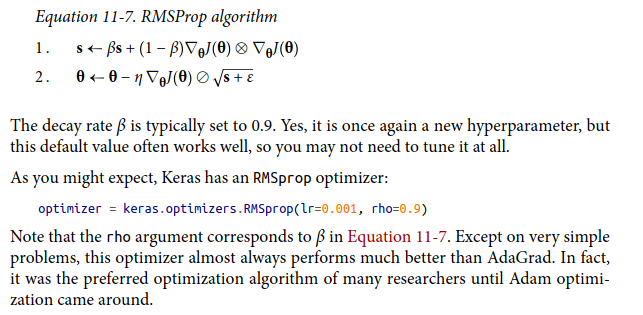

---
## Adam, AdaMax and Nadam Optimizer
```
Adam stands for adaptive momentum estimation, combines idea of momentum optimization and RMSProp
It keeps track of an exponentially decaying average of past gradients;
and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients
```
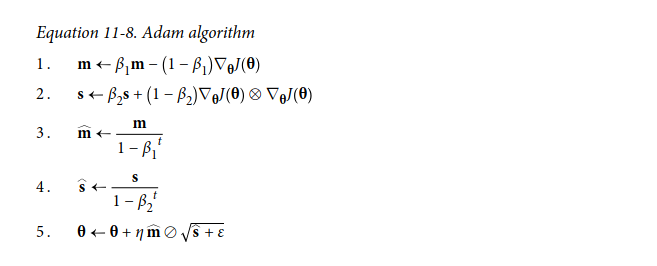
```
In step 1,2,5 it works similar to Momen Optim and RMSProp, but it calculates
exponentially decaying avg rather than exponentially decaying sum since
the decaying average is just 1 – β1 times the decaying sum

In step 3,4 the initial bias towards 0(start point) of m and s is optimized.

The momentum decay hyperparameter β1 is typically initialized to 0.9, while the scal‐
ing decay hyperparameter β2 is often initialized to 0.999. As earlier, the smoothing
term ε is usually initialized to a tiny number such as 10–7.


In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

---
```
AdaMax
     is not really better for many of task from Adam optim, it just calculate exp decaying max rather than average

Nadam
    is Adam optim + Nesterov trick, it just slightly converge faster than Adam but, sometimes outperformed by RMSProp
```
---
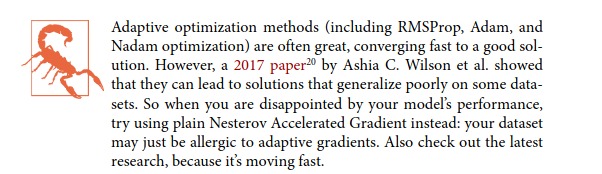

---
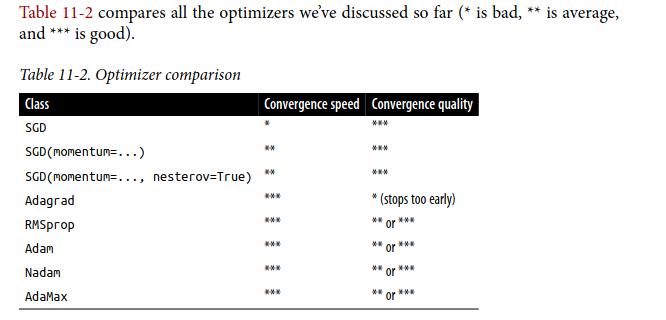
```
All of above optimizer algo rely on First-Order partial derivation (Jacobians).
There are many 2nd Order partial derivative (Hessian) too but,
they output n2 Hessians per output (often don't fit memory since NN have ten of thousands of param)

---
## Learning Rate Scheduling


---
## Avoiding Overfitting Through Regularization
> #### Early Stopping
> #### Batch Normalization
> #### l1 and l2 regularization
> #### Dropout layer
> #### Marco-Carlo Dropout (MC Dropout)
> #### MaxNorm regularization

---
## l1 and l2 regularization
```
For simple linear models, you can use ℓ2 regularization
to constrain a neural network’s connection weights, and/or ℓ1 regularization if you
want a sparse model (with many weights equal to 0)

Using keras.regularizers.l1(), keras.regularizers.l1_l2(), etc

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                                kernel_initializer="he_normal",
                                kernel_regularizer=keras.regularizers.l2(0.01))

---
## Droput layer
```
It is a state-of-the-art technique proven to get 1-2% accuracy boost such that even 95% acc model can be improved
It simply dropped-out or ignores p neurons during training step, may get active in next
The hyperparameter p is called the dropout rate

It is typically set between 10% and 50% (ANN)
closer to 20–30% in recurrent neural nets(RNN),
and closer to 40–50% in convolutional neural network(CNN)
```
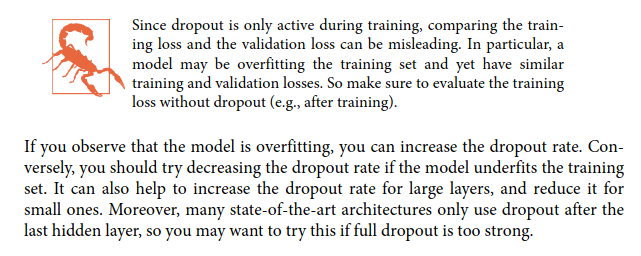